# Courbes de niveau - DENIG Pierre & COMMUNAL Théo

## Table des matières

- Préambule

  - Dépendances logicielles

  - Différentiation automatique

- Ensembles de niveau

  - Exemples de référence

  - Analyse des ensembles de niveau (Q1, Q2, Q3, Q4)

- Construction des courbes de niveau

  - Méthode de Newton (Q5, T1, T2)

  - Génération des points (Q6, T3)

  - Bouclage et auto-intersection (Q7, T4, T5)

- Post-traitement

  - Interpolation (Q8, T6)

  - Intégration (T7, T8)

## Préambule

### Dépendances logicielles 

In [1]:
# Python Standard Library
# -----------------------
pass

In [2]:
# Third-Party Libraries
# ---------------------

# Autograd & Numpy
import autograd
import autograd.numpy as np

# Pandas
import pandas as pd

# Matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10] # [width, height] (inches). 

# Jupyter & IPython
from IPython.display import display

### Différentation automatique

On définit ici deux fonctions utilitaires, `grad` et `J`, permettant de calculer simplement le gradient d'une fonction scalaire de deux variables réelles et la matrice jacobienne d'une fonction vectorielle de deux variables réelles.

In [3]:
def grad(f):
    g = autograd.grad
    def grad_f(x, y):
        return np.array([[g(f, 0)(x, y), g(f, 1)(x, y)]])
    return grad_f

In [4]:
def J(f):
    j = autograd.jacobian
    def J_f(x, y):
        return np.array([j(f, 0)(x, y), j(f, 1)(x, y)]).T
    return J_f

#### Exemples d'usage

In [5]:
def f(x, y):
    return np.sin(x) + 2.0 * np.sin(y)

grad_f = grad(f)

grad_f(0.0, 0.0) # array([1., 2.])

array([[1., 2.]])

In [6]:
def f(x, y):
    return np.array([x + 2 * y, 3 * x + 4 * y])

J_f = J(f)

J_f(0.0, 0.0) # array([[1., 2.], [3., 4.]])

array([[1., 2.],
       [3., 4.]])

#### Précautions

Les deux sources d'erreurs (avec messages cryptiques) les plus communes avec autograd :

**Selection de NumPy**

N'importez pas NumPy directement, par exemple avec

    >>> import numpy as np # Wrong !

mais importez le module `numpy` qui a été modifié par `autograd` (pour que les fonctions du module "coopérent" avec les algorithmes de différentiation automatique). 

    >>> import autograd.numpy as np # Right !
    
Utilisez-le ensuite comme vous le feriez avec NumPy classique.

**Utilisez des doubles**

Les fonctions générées par autograd sont strictes quand au type des nombres utilisés (plus strictes que les fonctions NumPy) : il doit s'agir de doubles. Par exemple, si l'on définit

    >>> def add(x, y):
    ...    return x + y
    >>> grad_add = grad(add)

Alors `grad_add(0.0, 0.0)` renvoie `array([1.0, 1.0])`, mais `grad_add(0, 0)` génère une erreur, car ses arguments sont des entiers et non des doubles.


## Ensembles de niveau

On appelle *ensemble de niveau* $c \in \mathbb{R}$ d'une fonction $f : \mathbb{R}^2 \to \mathbb{R}$  l'ensemble du plan
$$
\{(x_1,x_2) \in \mathbb{R}^2 \; | \; f(x_1, x_2) = c\}.
$$


### Exemples de référence

On définit ici quelques fonctions qui pourront servir de référence pour valider les algorithmes de génération de courbes de niveau. On pourra également utiliser la fonction utilitaire `display_contour` ci-dessous, qui exploite [la fonction `contour` de Matplotlib](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.contour.html) pour représenter une collection d'ensembles de niveau.

In [7]:
def display_contour(f, x, y, levels):
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    fig, ax = plt.subplots()
    contour_set = plt.contour(
        X, Y, Z, colors="grey", linestyles="dashed", 
        levels=levels 
    )
    ax.clabel(contour_set)
    plt.grid(True)
    plt.xlabel("$x_1$") 
    plt.ylabel("$x_2$")
    plt.gca().set_aspect("equal")

#### Fonction quadratique

In [8]:
def f1(x1, x2):
    x1 = np.array(x1)
    x2 = np.array(x2)
    return 3.0 * x1 * x1 - 2.0 * x1 * x2 + 3.0 * x2 * x2 

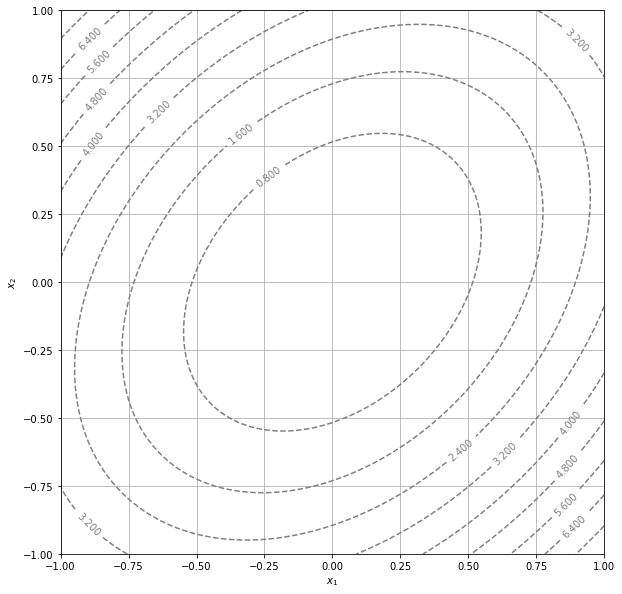

In [9]:
display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)

#### Fonction de Rosenbrock

Source : [Fonction de Rosenbrock, Wikipédia](https://en.wikipedia.org/wiki/Rosenbrock_function)

$$
f_2 : (x_1,x_2) \in \mathbb{R}^2 \mapsto (x_1 - 1)^2 + (x_1 - x_2^2)^2
$$

In [10]:
def f2(x1, x2):
    return (x1 - 1)**2 + (x1 - x2**2)**2

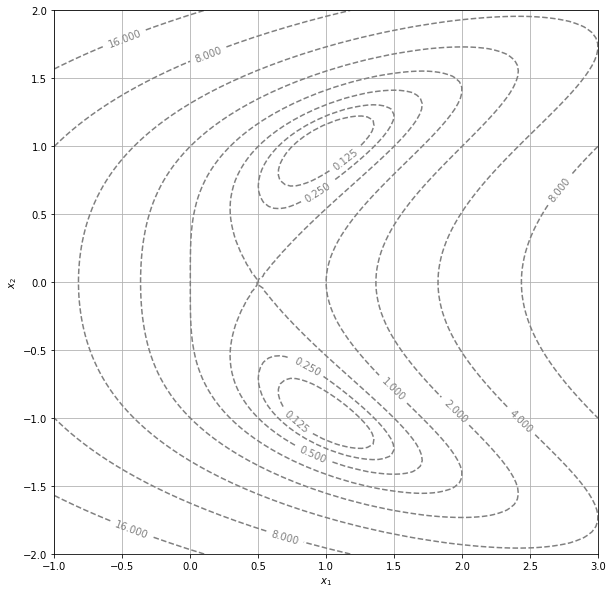

In [11]:
display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)

#### Fonction complexe

Source: [Courbe implicite, Wikipédia](https://en.wikipedia.org/wiki/Implicit_curve)

In [12]:
def f3(x, y):
    return np.sin(x + y) - np.cos(x * y) - 1 + 0.001 * (x * x + y * y) 

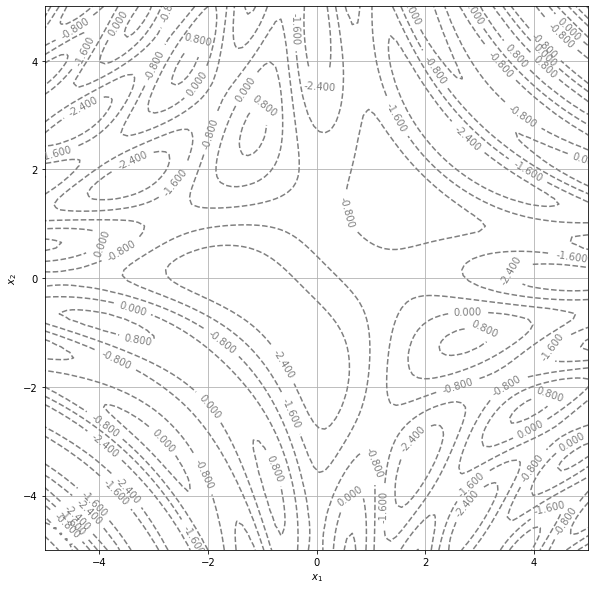

In [13]:
display_contour(
    f3, 
    x=np.linspace(-5.0, 5.0, 100), 
    y=np.linspace(-5.0, 5.0, 100), 
    levels=5, # 5 levels, automatically selected
)

### Analyse des ensembles de niveau

#### Question 1

Soit $c \in \mathbb{R}$.
On suppose que la fonction $f:\mathbb{R}^2 \to \mathbb{R}$ est continue et vérifie
$f(x_1, x_2) \to +\infty$ quand $\|(x_1,x_2)\| \to +\infty$.
Que peut-on dire de l'ensemble de niveau $c$ de $f$ ?

----
## __Réponse 1__
Dans la suite on notera $C_{f}(c)$ l'ensemble de niveau c pour une fonction f.

On va montrer que pour f continue et verifiant $f(x_1, x_2) \to +\infty$ quand $\|(x_1,x_2)\| \to +\infty$ on a la propriété $\forall c \in \mathbb{R},\,C_{f}(c)$ est compact. Comme nous travaillons en dimension finie, il suffit de montrer que $C_f(c)$ est un fermé borné.  

 - __Aspect fermé:__

      Soit $c \in \mathbb{R}$ et $x_{n} \in C_{f}(c)^{\mathbb{N}}$ telle que $x_n$ converge vers $x$. Il suffit donc de montrer que $x \in C_f(c)$ d'après la caractérisation séquentielle des fermés. 
    On a $\forall n\in\mathbb{N},f(x_n) = c$. Ainsi d'après la caractérisation séquentielle de la continuité, $\lim_{n \rightarrow \infty} f(x_n) = f(x) = c$. Donc $x\in C_f(c)$. D'où le résultat. 

- __Aspect borné:__

    Soit $c \in \mathbb{C}$. Supposons que $C_f(c)$ ne soit pas borné. Comme $f(x_1, x_2) \to +\infty$ quand $\|(x_1,x_2)\| \to +\infty$, on peut trouver $A\in\mathbb{R}$ tel que $\forall x\in\mathbb{R}^2,\|x\| > A \Rightarrow f(x) > c +1$. Ainsi, si $C_f(c)$ n'est pas borné on peut trouver $x\in C_f(c)$ tel que $\|x\|>A$. D'où la contradiction !
    Donc $C_f(c)$ est borné.

Ainsi la propriété est vraie.

-----

Dans la suite la fonction $f$ est supposée continûment différentiable. On suppose également que le gradient $\nabla f$ ne s'annule pas dans un voisinage du point $x_0 = (x_{10}, x_{20}) \in \mathbb{R}^2$. On pose alors
$$
p(x_1, x_2) := \frac{\partial_2 f(x_0)}{\|\nabla f(x_0)\|} (x_1 - x_{10}) -
\frac{\partial_1 f(x_0)}{\|\nabla f(x_0)\|} (x_2 - x_{20}).
$$




#### Question 2
Comment interpréter géométriquement le terme $p(x_1,x_2)$ ?

---
## __Réponse 2__

On a $\nabla f(x_0) = \left(\begin{matrix} \partial_1 f(x_0)  \\ \partial_2 f(x_0) \end{matrix} \right)$. 
Donc $ \vec u(x_0) = \frac{1}{\|\nabla f(x_0)\|}\cdot \left(\begin{matrix} \partial_2 f(x_0)  \\ -\partial_1 f(x_0) \end{matrix} \right) $ est un vecteur orthogonal à $\nabla f(x_0)$ et de norme 1.

Ainsi on a en posant $x = (x_1,x_2)$, $p(x) = \langle \vec u(x_0) | x-x_0 \rangle$ ce qui correspond à la norme de la projection du vecteur $x-x_0$ sur la tangente à la courbe de niveau $\{f(x) = f(x_0)\}$. Ou, connaissant la norme du vecteur $x-x_0$, on en tire l'angle entre le vecteur $x-x_0$ et la tangente à la courbe de niveau en $x_0$. 


---

#### Question 3

Montrer que dans un voisinage ouvert de $x_0$, on peut paramétriser l'ensemble de niveau $c:=f(x_0)$ au moyen de $p(x_1,x_2),$ c'est-à-dire qu'il existe un $\varepsilon > 0$ et une fonction (continûment différentiable) $\gamma :\left]-\varepsilon,\varepsilon \right[ \to \mathbb{R}^2$ tels que dans un voisinage ouvert de $x_0,$ $f(x_1,x_2) = c$ si et seulement si $(x_1, x_2) = \gamma(t)$ où $t = p(x_1, x_2)$.

---
## __Réponse 3__

On suppose c = 0 quitte à considérer $f-c$.

$f$ est une fonction continuement différentiable et $\nabla f$ ne s'annule pas dans un vosinnage de $x_0$.
Soit $F(x,t) = (f(x),t-p(x))$. $F$ est continuement différentiable car $f$ l'est et $p$ aussi en tant que produit scalaire.
On a $\partial_x F(x) =  
    \left(\begin{matrix}
    \partial_1 f(x) & \partial_2 f(x) \\
    \frac{\partial_2 f(x_0)}{\|\nabla f(x_0)\|} & -\frac{\partial_1 f(x_0)}{\|\nabla f(x_0)\|}
    \end{matrix}\right)$. 
    
On a donc $\det(\partial_x F(x,t)) = -\frac{\partial_1 f(x) \partial_1 f(x_0) + \partial_2 f(x) \partial_2 f(x_0)}{\|\nabla f(x_0)\|}$. On a en particulier $det(\partial_xF(x_0,t)) = -1$. Comme le déterminant est continu, on peut donc trouver un voisinnage de $x_0$ sur lequel $x \rightarrow det(\partial_xF(x,t))$ ne s'annule pas pour tout $t\in\mathbb{R}$. 

Ainsi d'après le théorème des fonctions implicites, il existe $U$ et $V$ des voisinnages de $x_0$ et $0$ ainsi que $\gamma : V \rightarrow \mathbb{R}^2$ telle que $F(x,t) = 0 \iff x = \gamma(t)$. 
Comme $V$ est un voisinnage de $0$, il existe $\epsilon > 0$ tel que $]-\epsilon, \epsilon[ \subset V$. On considère donc $\gamma_{|]-\epsilon,\epsilon[}$ que l'on appelle toujours $\gamma$. 
De plus on a $d\gamma(t) = - [(\partial_x F)^{-1}\circ\partial_tF](\gamma(t),t)$

Ainsi en cherchant les $0$ de $F$ on a $F(x,t) = 0 \iff \left\{\begin{matrix} f(x) = 0 \\ t = p(x) \end{matrix}\right\} \iff x = \gamma(t)$. 

D'où $f(x) = 0 \iff x = \gamma(t) = \gamma(p(x))$. 

---

#### Question 4

Montrer que pour tout $t \in \left]-\varepsilon, \varepsilon \right[$ :

  - le vecteur $\gamma'(t)$ est non nul (il fournit donc une tangente au chemin $\gamma$),

  - est orthogonal à $\nabla f(\gamma(t))$.

---
## __Réponse 4__

- D'après ce qui précède on a $$\gamma'(t) = d\gamma(t) = \left[-   [(\partial_x F)^{-1}\circ\partial_tF](\gamma(t),t)\right] = - \left(\begin{matrix}
    \partial_1 f(\gamma(t)) & \partial_2 f(\gamma(t)) \\
    \frac{\partial_2 f(x_0)}{\|\nabla f(x_0)\|} & -\frac{\partial_1 f(x_0)}{\|\nabla f(x_0)\|}
    \end{matrix}\right)^{-1}\cdot \left(\begin{matrix} 0 \\ 1 \end{matrix}\right) = \left(\begin{matrix}
    -\frac{\partial_1 f(x_0)}{\|\nabla f(x_0)\|} & -\partial_2 f(\gamma(t)) \\
    -\frac{\partial_2 f(x_0)}{\|\nabla f(x_0)\|} & \partial_1 f(\gamma(t)) 
    \end{matrix}\right) \cdot \left(\begin{matrix} 0 \\ 1 \end{matrix}\right) = \left(\begin{matrix} -\partial_2 f(\gamma(t)) \\ \partial_1 f(x) \end{matrix}\right) = \|\nabla f(x_0)\|\vec u (\gamma(t))$$

Donc comme $\|\gamma(t)\| = \|\nabla f(x_0)\| \ne 0$, $\gamma'$ ne s'annule pas sur $]-\epsilon,\epsilon[$ puisque $\nabla f$ ne s'annule pas au voisinnage de $x_0$.
   

- Soit $t\in ]-\epsilon,\epsilon[$, on a $f(\gamma(t)) = c$. Donc en dérivant par rapport à $t$ on a $\langle \nabla f(\gamma(t)) | \gamma'(t) \rangle = 0$. D'où le résultat. 


---

## Construction des courbes de niveau

### Méthode de Newton

Afin de trouver des points sur des courbes de niveau, on souhaite implémenter un algorithme de résolution des équations de la forme $F(x) = 0$ où $F: \mathbb{R}^2 \to \mathbb{R}^2$, par la méthode de Newton, amorcée par un point de référence $x_0 \in \mathbb{R}^2$.

L'implémentation prendra la forme générale donnée ci-dessous. L'appel `x, y = Newton(F, x0, y0, eps, N)` devra renvoyer le couple des coordonnées d'un point $(x, y)$ qui est une solution approchée de $F(x,y)=0$ à proximité de $(x_0, y_0)$. La qualité de l'approximation produite est déterminée par le réel positif $\varepsilon > 0$, une approximation de la distance entre le point $(x,y)$ renvoyé par la fonction et la solution exacte. L'algorithme itératif s'interrompra si aucune approximation de la précision souhaitée n'a été trouvée en $N$ étapes. 

#### Question 5

L'application à laquelle nous destinons la fonction `Newton` demande-t'elle une grande précision ?
Choisir une valeur de `eps` qui semble raisonnable et justifier l'ordre de grandeur choisi.

---
## __Réponse 5__

Dans la fonction `Newton` qui sera implémentée plus tard, on utilise la distance entre 2 points. On doit donc avoir $\sqrt{2\epsilon_{machine}} \leq eps$. Donc $eps \geq \sqrt{\epsilon_{machine}}$. Or plus le choix de $eps$ est petit, plus il faut d'itérations pour arriver à la précision voulue avec la méthodé de Newton. De plus, notre but étant de tracer les lignes de niveau, la précision du tracé est limité par l'épaisseur de la ligne tracée. Donc la précision n'a pas besoin d'être de l'ordre de l'$\epsilon_{machine}$. D'où le choix de $eps = 10^{-4}$. 

---

In [14]:
N = 100
eps = 10**(-4)

#### Tâche 1

Implémenter la fonction `Newton` en complétant le canevas ci-dessous

---

## __Explication de l'algorithme__

On va s'inspirer de la méthode de Newton pour les fonctions de $\mathbb{R}$ dans $\mathbb{R}$. Pour que cette méthode fonctionne on doit se limiter à un intervalle de travail où la fonction strictement monotone.
Dans le cas $\mathbb{R} \rightarrow \mathbb{R}$ on définit par récurrence une suite $(x_k) \in \mathbb{R}^{\mathbb{N}}$ par la relation de récurrence $x_{k+1} = x_k - \frac{f(x_k)}{f'(x_k)}$.

Dans le cas $\mathbb{R}^2 \rightarrow \mathbb{R}^2$ on définit une suite $(x_k) \in (\mathbb{R}^2)^{\mathbb{N}}$ telle que $J_f(x_k)\cdot(x_{k+1} - x_k) + f(x_k) = 0$. Ainsi le jacobien de f doit être inversible dans un voisinage du zéro recherché. 

On obtient donc $$x_{k+1} = x_k - ( J_f(x_k))^{-1}\cdot f(x_k)$$

---

In [15]:
def Newton(F, x0, y0, eps=eps, N=N): #Renvoie uniquement le dernier point calculé
    x,y = x0,y0
    J_F = J(F)
    for i in range(N):  
        x,y = np.array([x0,y0]) - np.dot(np.linalg.inv(J_F(x0,y0)),F(x0,y0))
        dist = np.sqrt((x - x0)**2 + (y - y0)**2)
        if  dist <= eps:
            return x, y
        x0, y0 = x, y
    else:
        raise ValueError(f"no convergence in {N} steps.")
        
def Newton2(F, x0, y0, eps=eps, N=N):#Renvoie tous les points calculés successivement
    x,y = x0,y0
    J_F = J(F)
    X,Y = [x],[y]
    for i in range(N):  
        x,y = np.array([x0,y0]) - np.dot(np.linalg.inv(J_F(x0,y0)),F(x0,y0))
        X.append(x)
        Y.append(y)
        dist = np.sqrt((x - x0)**2 + (y - y0)**2)
        if  dist <= eps:
            return X,Y
        x0, y0 = x, y     
    else:
        print(ValueError(f"no convergence in {N} steps."))
        return X,Y

#### Tâche 2

Testez votre implémentation de la fonction `Newton` ! On suggère par exemple de l'utiliser pour chercher un point $(x_1, x_2)$ de la ligne de niveau $0.8$ de $f_1$ (cf. Exemples de référence) qui vérifie en outre $x_1 = x_2$ en utilisant le point initial $(0.8, 0.8)$. Puis de faire varier le point initial, la contrainte supplémentaire, etc. et de représenter graphiquement les résultats.

---
## __Résultat tâche 2__

Pour afficher graphiquement ce que fait la fonction `Newton2`, cette dernière ne renvoie pas seulement le point trouvé mais tous les points calculés successivement. On affiche ces points avec les lignes de niveaux de la fonction $f_1$. Le dernier point calculé est affiché en rouge. 

On remarque que la fonction `Newton` s'applique à une fonction $F : \mathbb{R}^2 \rightarrow \mathbb{R}^2$. Or les fonctions de références sont des fonction $f_i : \mathbb{R}^2 \rightarrow \mathbb{R}$.

Pour pouvoir utiliser la fonction `Newton` on va rajouter une condition $C : \mathbb{R}^2 \rightarrow \mathbb{R}$ qui est verifée seulement si $C(x) = 0$.

On applique donc la fonction `Newton` à la fonction $F(x) = (f(x),C(x))$.

---

### __Illustration avec la fonction f1 aux points (0.8,0.8) et (-0.6,-0.9) pour la valeur 0.8__

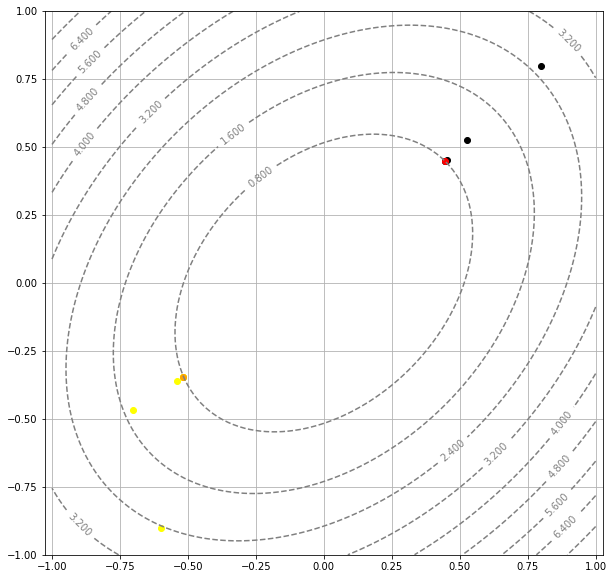

In [16]:
def f(x,y):
    return f1(x,y) - 0.8
def C(x,y): #Condition 1
    return x-y
def C2(x,y): #Condition 2
    return 2*x-3*y 
def F(x,y):
    return np.array([f(x,y),C(x,y)])
def F2(x,y):
    return np.array([f(x,y),C2(x,y)])
    
X,Y = Newton2(F,0.8,0.8)
plt.scatter(X,Y,c='black')
plt.scatter(X[-1],Y[-1],c='r')

X1,Y1 = Newton2(F2,-0.6,-0.9)
plt.scatter(X1,Y1,c='yellow')
plt.scatter(X1[-1],Y1[-1],c='orange')

X0,Y0 = np.linspace(-1,1,100),np.linspace(-1,1,100)
X0,Y0 = np.meshgrid(X0,Y0)
Z = f1(X0,Y0)
CS = plt.contour(X0,Y0,Z,linestyles = 'dashed',colors = 'grey',levels = 10)
plt.clabel(CS);

plt.xlim([-1,1]);
plt.ylim([-1,1]);
plt.axis('equal');
plt.grid()

### __Illustration avec la fonction f2 au point (0.5,-1) pour la valeur 1__

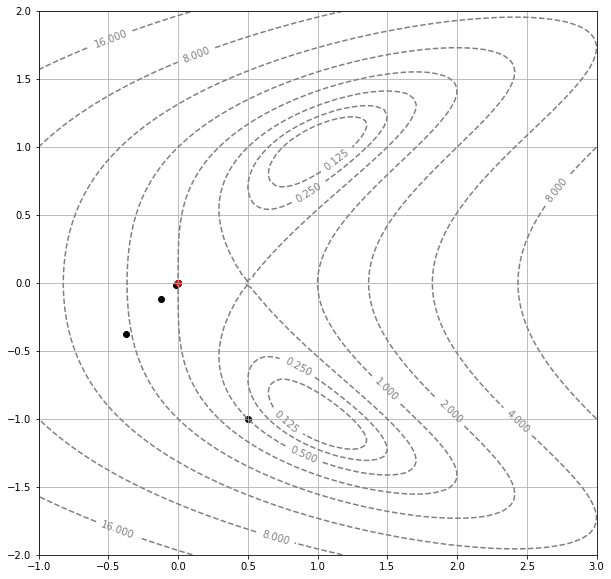

In [17]:
def f(x,y):
    return f2(x,y) - 1
def C(x,y):
    return x-y
def F(x,y):
    return np.array([f(x,y),C(x,y)])
    
X,Y = Newton2(F,0.5,-1.0)
plt.scatter(X,Y,c='black')
plt.scatter(X[-1],Y[-1],c='r')

X0,Y0 = np.linspace(-1,3,100),np.linspace(-2,2,100)
X0,Y0 = np.meshgrid(X0,Y0)
Z = f2(X0,Y0)
CS = plt.contour(X0,Y0,Z,linestyles = 'dashed',colors = 'grey',levels = [2**i for i in range(-3, 8)])
plt.clabel(CS);

plt.xlim([-1,3]);
plt.ylim([-2,2]);
plt.grid()

### __Illustration avec la fonction f3 au point (0,0) pour la valeur 2.4__

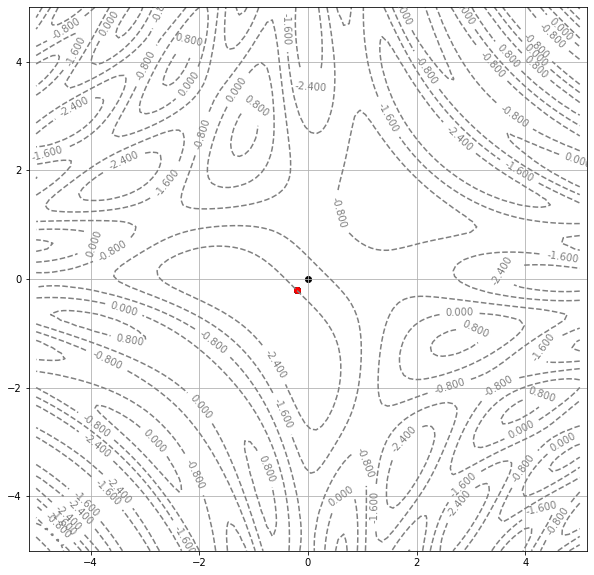

In [18]:
def f(x,y):
    return f3(x,y) + 2.4
def C(x,y):
    return x-y
def F(x,y):
    return np.array([f(x,y),C(x,y)])
    
X,Y = Newton2(F,-0.0,0.0)
plt.scatter(X,Y,c='black')
plt.scatter(X[-1],Y[-1],c='r')

X0,Y0 = np.linspace(-5,5,100),np.linspace(-5,5,100)
X0,Y0 = np.meshgrid(X0,Y0)
Z = f3(X0,Y0)
CS = plt.contour(X0,Y0,Z,linestyles = 'dashed',colors = 'grey',levels = 5)
plt.clabel(CS);

plt.xlim([-5,5]);
plt.ylim([-5,5]);
plt.axis('equal');
plt.grid()

### Génération des points

#### Question 6 + Tâche 3
Comment, en partant d'un point de référence $(x_0, y_0)$ tel que $f(x_0, y_0)=c$, peut-on générer avec la méthode de Newton un point $(x_1, y_1)$ également tel que $f(x_1, y_1) = c$, mais à une distance $\delta > 0$ de $(x_0, y_0)$ et qui soit "à droite" quand on est en $(x_0, y_0)$ et qu'on regarde dans la direction de $\nabla f(x_0, y_0)$ ? Implémenter la fonction `level_curve` qui répète ce procédé $N-1$ fois et renvoie un tableau NumPy de taille `(2, N)` contenant les coordonnées des points correspondants, puis valider graphiquement le résultat au moyen des exemples de référence.

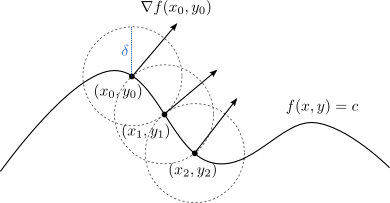

--- 
## __Réponse 6__

Soit $\delta > 0$. Supposons que nous disposions d'un point $ \vec x_0 = (x_0,y_0)$ tel que $f(x_0,y_0) = c$. 
D'après ce qui a été fait avant, on a $\nabla f(x)$ perpendiculaire à la courbe de niveau en $x$.

Concrètement on cherche un point $(x_1,y_1)$ vérifiant le système $ \left(\begin{matrix} f(x_1,y_1) = c \\ \|(x_1,y_1) - (x_0,y_0)\| = \delta \end{matrix} \right)$.

Soit $\vec v = \left(\begin{matrix} \partial_y f(x) \\ -\partial_x f(x) \end{matrix} \right)$. On pose $\vec u = \frac{1}{\|\vec v\|} \cdot \vec v$. On a donc $\vec u$ qui est un vecteur tangent à la courbe de niveau en $x$. Posons $(x'_0,y'_0) = (x_0,y_0) + \delta \vec u$.

En posant $F(x) = (f(x)-c,\|\vec x_0 - x\| - \delta)$, il suffit de prendre `(x1,y1) = Newton(F,x0,y0)`. 




---


In [19]:
def level_curve(f, x0, y0, delta=0.1, N2=1000, eps=eps):
    grad_f = grad(f)
    X,Y = [x0],[y0]
    x,y = x0,y0
    def F(x,y,x1,y1):
        return np.array([f(x,y),np.sqrt((x-x1)**2 + (y-y1)**2) - delta])
    for i in range(N2):
        gf = grad_f(x,y)
        u = np.array([gf[0,1],-gf[0,0]])
        u = u/np.linalg.norm(u)
        x,y = x + delta*u[0],y + delta*u[1]
        x,y = Newton(lambda a,b : F(a,b,X[-1],Y[-1]), x,y)
        X.append(x)
        Y.append(y)
    return np.array([X,Y])

---
## __Résultats tâche 3__

---

### __Illustration avec la fonction f1 pour la courbe f(x) = 0.8__

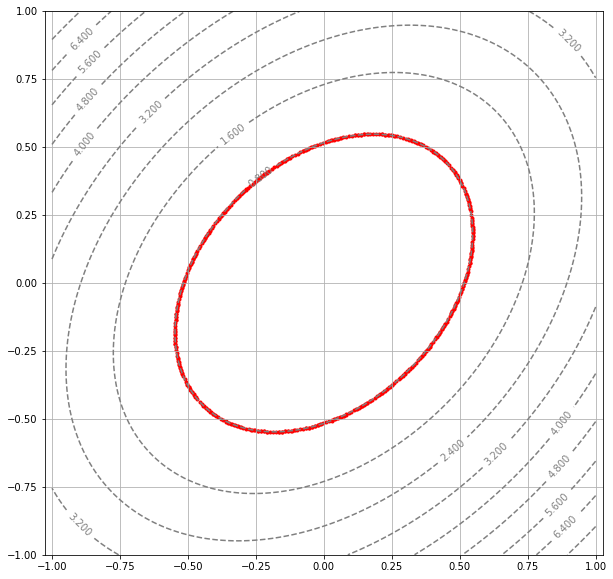

In [20]:
def f(x,y):
    return f1(x,y) - 0.8
def f_n(x,y):
    return np.array([f(x,y),C(x,y)])
x,y = Newton(f_n,0.8,0.8)
XY = level_curve(f,x,y,N2 = 500)

X0,Y0 = np.linspace(-1,1,100),np.linspace(-1,1,100)
X0,Y0 = np.meshgrid(X0,Y0)
Z = f1(X0,Y0)
CS = plt.contour(X0,Y0,Z,linestyles = 'dashed',colors = 'grey',levels = 10)
plt.clabel(CS);

plt.scatter(XY[0,::],XY[1,::],c='r',marker='.');
plt.xlim([-1,1]);
plt.ylim([-1,1]);
plt.axis('equal');
plt.grid()

### __Illustration avec la fonction f2 pour la courbe f2(x) = 1__

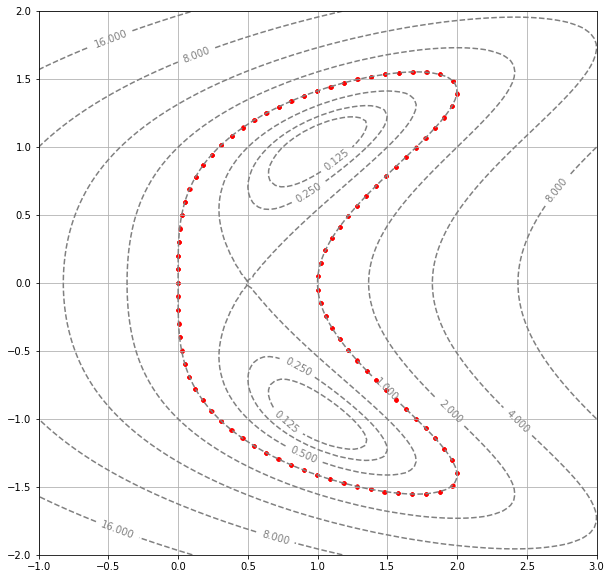

In [21]:
def f(x,y):
    return f2(x,y) - 1.0
def f_n(x,y):
    return np.array([f(x,y),C(x,y)])
x,y = Newton(f_n,0.5,-1.0)
XY = level_curve(f,x,y,N2 = 500)

X0,Y0 = np.linspace(-1,3,100),np.linspace(-2,2,100)
X0,Y0 = np.meshgrid(X0,Y0)
Z = f2(X0,Y0)
CS = plt.contour(X0,Y0,Z,linestyles = 'dashed',colors = 'grey',levels = [2**i for i in range(-3, 8)])
plt.clabel(CS);

plt.scatter(XY[0,::],XY[1,::],c='r',marker='.');
plt.xlim([-1,3]);
plt.ylim([-2,2]);
plt.grid()

### __Illustration avec la fonction f3 pour la courbe f(x) = -2.4__

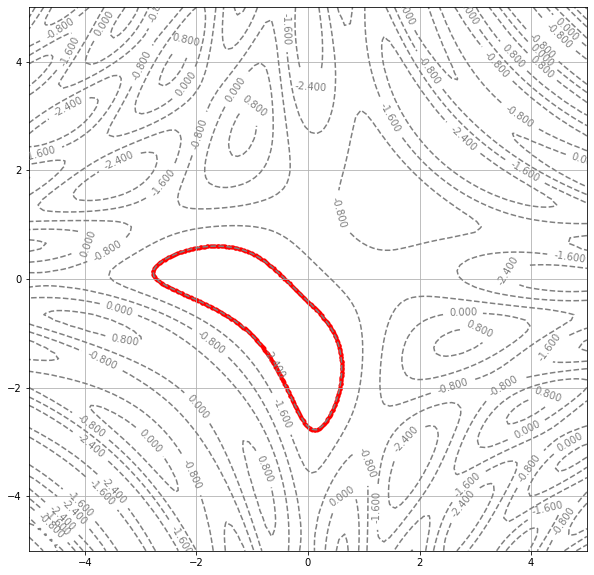

In [22]:
def f(x,y):
    return f3(x,y) + 2.4
def f_n(x,y):
    return np.array([f(x,y),C(x,y)])
x,y = Newton(f_n,0.0,0.0)
XY = level_curve(f,x,y,N2 = 500)

X0,Y0 = np.linspace(-5,5,100),np.linspace(-5,5,100)
X0,Y0 = np.meshgrid(X0,Y0)
Z = f3(X0,Y0)
CS = plt.contour(X0,Y0,Z,linestyles = 'dashed',colors = 'grey',levels = 5)
plt.clabel(CS);

plt.scatter(XY[0,::],XY[1,::],c='r',marker='.');
plt.xlim([-5,5]);
plt.ylim([-5,5]);
plt.grid()

### Bouclage et auto-intersection

L'algorithme précédent est malheureusement susceptible de faire plusieurs fois le tour d'une courbe de niveau donnée. 

#### Question 7 + Tâche 4

Proposer une nouvelle implémentation de `level_curve` qui arrête l'algorithme et renvoie les points connus quand le segment formé par les deux derniers points produits intersecte l'un des segments produits auparavant. En étant (raisonnablement) optimiste, doit-t'on prendre la peine de tester l'intersection du dernier segment avec tous les segments déjà produits (ce qui prend du temps ...) ou juste avec le premier ? Pour répondre à cette question, on pourra se demander si les courbes de niveau similaires à celle de la fonction de Rosenbrock passant par le point $(0.5, 0)$ (cf. Exemples de référence) -- c'est-à-dire "auto-intersectantes" -- sont fréquentes ou rares et pourquoi.

---
## __Réponse 7__

- Soient $A=(x_A,y_A)$,$B=(x_B,y_B)$,$C=(x_C,y_C)$,$D=(x_D,y_D) \in \mathbb{R}^2$.

Si $[A,B]\cap [C,D] \neq \emptyset$ alors $\exists (t_1,t_2) \in [0,1]^2$ tels que $t_1A+(1-t_1)B = t_2C + (1-t_2)D$. Donc
$\left\{\begin{matrix} t_1x_A + (1-t_1)x_B = t_2x_C + (1-t_2)x_D \\ t_1y_A + (1-t_1)y_B = t_2y_C + (1-t_2)y_D \end{matrix}\right\}$. 

En posant $A = \left(\begin{matrix} x_A-x_B & x_D-x_C \\ y_A-y_B & y_D-y_C\end{matrix}\right)$et $B = \left(\begin{matrix} x_D - x_B \\ y_D - y_B \end{matrix}\right)$, on a $A\cdot\left(\begin{matrix}t_1 \\ t2\end{matrix}\right) = B$.

Ainsi,  $[A,B]\cap [C,D] \neq \emptyset \iff \left\{ \begin{matrix} det(A) \neq 0 \\ ou \\ det(A) = 0 \,et\, il\, existe\, un\, segment\, I\, non\, trivial\, tel\, que\, I\subset [A,B]\cap [C,D] \end{matrix}\right\}$.

Nous ne pouvons donc pas gérer le cas où $det(A) = 0$ et où le système admet une infinité de solution via cette méthode. On va donc utiliser une autre méthode.

Soient $\vec p_1 = \vec {AB} \land \vec {CD}$ , $\vec p_2 = \vec {AB} \land \vec {AD}$ , $\vec p_3 = \vec {AB} \land \vec {AC}$ , $\vec p_4 = \vec {CD} \land \vec {BC}$ et $\vec p_5 = \vec{CD} \land \vec {AC}$. 

Alors on peut montrer que $[A,B]\cap [C,D] \neq \emptyset \iff \left\{\begin{matrix} p_1 \neq \vec 0 \\ \vec p_2 \cdot \vec p_3 \leq 0 \\ \vec p_4 \cdot \vec p_5 \leq 0 \end{matrix}\right\}$


- Si l'on observe des systèmes naturels macroscopiques, on remarquera que les courbes auto-interséctantes sont très peu fréquentes dans la nature. Cependant, au niveau microscopique, les mouvements browniens font très souvent apparaitre des courbes auto-interséctantes. Néanmoins, dans tous les cas, si l'on fait l'étude cinématique (dans le cadre classique) du système, on est ammené à considérer l'espace des phases du système où l'on est garanti de ne trouver aucune courbe auto-interséctante d'après le théorème de Cauchy-Lipschitz même dans l'étude de systèmes chaotiques où les trajectoires dans l'espace des phases sont certes très proches comme le montre l'attracteur de Lorentz mais ne se coupent pas. 

---

## __Implémentation tâche 4__

In [25]:
def new_level_curve(f, x0, y0, delta=0.1, N2=1000, eps=eps):
    grad_f = grad(f)
    X,Y = [x0],[y0]
    x,y = x0,y0
    def F(x,y,x1,y1):
        return np.array([f(x,y),np.sqrt((x-x1)**2 + (y-y1)**2) - delta])
    for i in range(N2):
        gf = grad_f(x,y)
        u = np.array([gf[0,1],-gf[0,0]])
        u = u/np.linalg.norm(u)
        x,y = x + delta*u[0],y + delta*u[1]
        x,y = Newton(lambda a,b : F(a,b,X[-1],Y[-1]), x,y)
        if i > 4:
            
            p0 = np.array([x0,y0,0])
            p1 = np.array([X[1],Y[1],0])
            p2 = np.array([X[-1],Y[-1],0])
            p3 = np.array([x,y,0])
            
            pv1 = np.cross((p1-p0),(p3-p2))
            pv2 = np.cross((p1-p0),(p3-p0))
            pv3 = np.cross((p1-p0),(p2-p0))
            pv4 = np.cross((p2-p3),(p2-p1))
            pv5 = np.cross((p2-p3),(p2-p0))
            ps1 = np.vdot(pv2,pv3)
            ps2 = np.vdot(pv4,pv5)
           
            
            if np.linalg.norm(pv1) != 0  and ps1 <= 0 and ps2 <= 0: 
                return np.array([X,Y])
            
        X.append(x)
        Y.append(y)
    return np.array([X,Y])

#### Tâche 5

Valider graphiquement le résultat au moyen des exemples de référence.

### __Illustration avec la fonction f1 pour la courbe f(x) = 0.8__

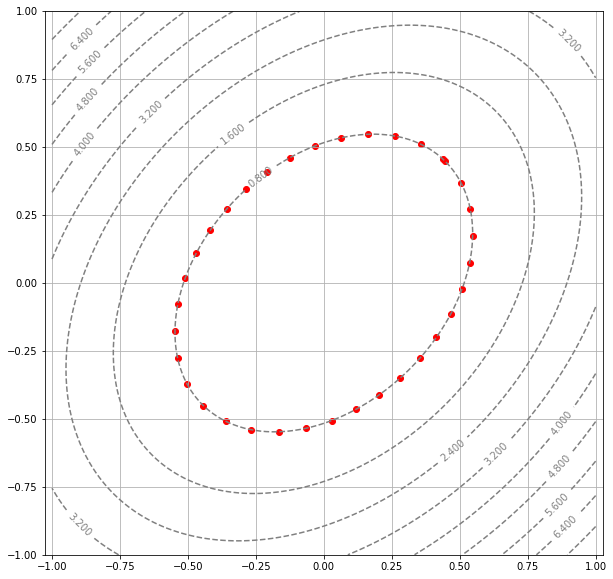

In [26]:
def f(x,y):
    return f1(x,y) - 0.8
def f_n(x,y):
    return np.array([f(x,y),C(x,y)])
x,y = Newton(f_n,0.8,0.8)
XY = new_level_curve(f,x,y,delta = 0.1, N2 = 500)

X0,Y0 = np.linspace(-1,1,100),np.linspace(-1,1,100)
X0,Y0 = np.meshgrid(X0,Y0)
Z = f1(X0,Y0)
CS = plt.contour(X0,Y0,Z,linestyles = 'dashed',colors = 'grey',levels = 10)
plt.clabel(CS);

plt.scatter(XY[0,::],XY[1,::],c='r');
plt.xlim([-1,1]);
plt.ylim([-1,1]);
plt.axis('equal');
plt.grid()

### __Illustration avec la fonction f2 pour la courbe f(x) = 0.5__

On voit ici le problème des courbes autointersectantes. 

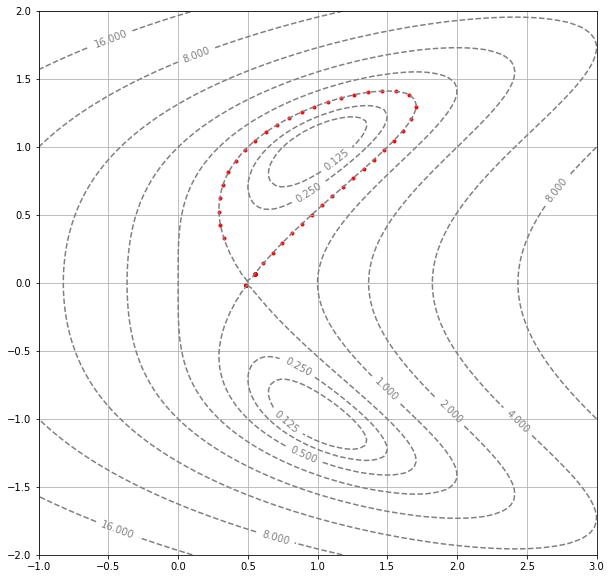

In [27]:
def f(x,y):
    return f2(x,y) - 0.5
def f_n(x,y):
    return np.array([f(x,y),C(x,y)])
x,y = Newton(f_n,0.5,-1.0)
XY = new_level_curve(f,x,y,N2 = 500)

X0,Y0 = np.linspace(-1,3,100),np.linspace(-2,2,100)
X0,Y0 = np.meshgrid(X0,Y0)
Z = f2(X0,Y0)
CS = plt.contour(X0,Y0,Z,linestyles = 'dashed',colors = 'grey',levels = [2**i for i in range(-3, 8)])
plt.clabel(CS);

plt.scatter(XY[0,::],XY[1,::],c='r',marker='.');
plt.xlim([-1,3]);
plt.ylim([-2,2]);
plt.grid()

### __Illustration avec la fonction f3 pour la courbe f(x) = -2.4__

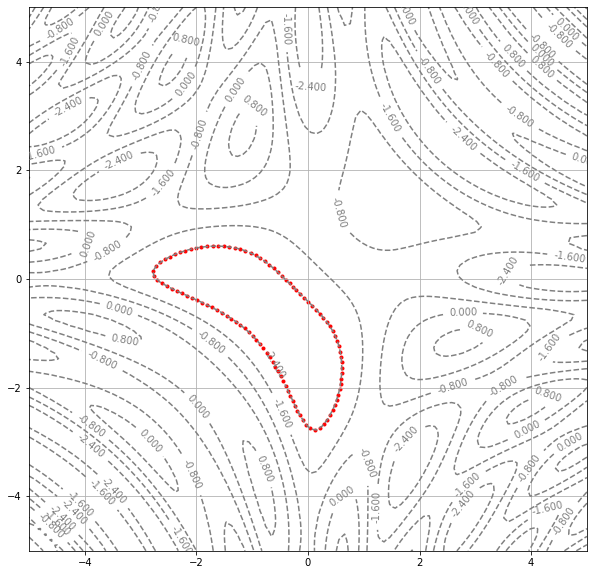

In [28]:
def f(x,y):
    return f3(x,y) + 2.4
def f_n(x,y):
    return np.array([f(x,y),C(x,y)])
x,y = Newton(f_n,0.0,0.0)
XY = new_level_curve(f,x,y,N2 = 500)

X0,Y0 = np.linspace(-5,5,100),np.linspace(-5,5,100)
X0,Y0 = np.meshgrid(X0,Y0)
Z = f3(X0,Y0)
CS = plt.contour(X0,Y0,Z,linestyles = 'dashed',colors = 'grey',levels = 5)
plt.clabel(CS);

plt.scatter(XY[0,::],XY[1,::],c='r',marker='.');
plt.xlim([-5,5]);
plt.ylim([-5,5]);
plt.grid()

## Post-traitement

Pour améliorer le rendu des courbes de niveau, il est tentant de diminuer la distance $\delta$ entre deux points consécutifs. Malheureusement, dans des cas d'usage réalistes, il est fréquent que la fonction $f$ soit beaucoup plus complexe que les exemples qui nous avons considérés. Le nombre de fois où cette fonction est appelée est alors le principal facteur qui détermine le temps de calcul des lignes de niveau. On cherche donc dans cette section à améliorer la qualité visuelle des résultats sans faire exploser le nombre d'évaluation de la fonction $f$. On va chercher à résoudre ce problème en reliant les points successifs par des chemins plus "flexibles" que des segments de droites, ayant le potentiel de mieux coller aux lignes de niveau.

### Interpolation 

#### Question 8

Soit $P_1$ et $P_2$ deux points du plan et $u_1$ et $u_2$ deux vecteurs du plan non nuls.
On cherche à produire un chemin $\gamma: [0,1] \to \mathbb{R}^2$ continûment différentiable, joignant $P_1$ et $P_2$ ($\gamma(0) = P_1$ et $\gamma(1) = P_2$), tel que $\gamma'(0)$ soit dans la même direction et le même sens que $u_1$ et $\gamma'(1)$ soit dans la même direction et le même sens que $u_2$.

On recherche une telle solution sous la forme
$\gamma(t) = (x(t), y(t))$ où 
$$
x(t) = a + bt + ct^2 \; \mbox{ et } \; y(t) = d + et + ft^2
$$
et les paramètres réels $a, b, c, d, e, f$ sont à déterminer(*).


Déterminer les coefficients $a, b, c, d, e, f$ solutions de ce problème quand ils existent.
Expliciter si nécessaire les conditions que doivent remplir $P_1$, $P_2$, $u_1$ et $u_2$ pour qu'une solution existe.

(*) Cf. ["Mathematical Typography" de Donald E. Knuth](https://projecteuclid.org/euclid.bams/1183544082) pp. 354-359 (Bull. Amer. Math. Soc. (N.S.), Volume 1, Number 2 (1979), 337-372), pour une classe de chemins interpolants similaire mais plus complexe.

---
## __Réponse 8__

On a $\gamma(t) = (a+bt+ct^2,d+et+ft^2)$ et $\gamma'(t) = (b+2ct,e+2ft)$. Donc $\left(\begin{matrix} \gamma(0) = (a,d) = P_1 \\ \gamma(1) = (a+b+c,d+e+f) = P_2\\ \gamma'(0) = (b,e) = \alpha u_1 \\ \gamma'(1) = (b+2c,e+2f) = \beta u_2 \end{matrix} \right)$ avec $\alpha,\beta > 0$.


Ainsi $\left(\begin{matrix} (a,d) = P_1 \\ (b+c,e+f) = P_2-P_1\\ (b,e) = \alpha u_1 \\ (c,f) = \beta u_2 + P_1 - P_2  \end{matrix} \right)$.

Il n'y a donc une solution si et seulement si $\alpha u_1 + \beta u_2 + P_1 + P_2 = P_2 - P_1 \iff \alpha u_1 + \beta u_2 = 2(P_2-P_1)$. On en déduit donc le système $\left(\begin{matrix}  \alpha u_1^1 + \beta u_2^1 = 2(P_2^1 - P_1^1) \\ \alpha u_1^2 + \beta u_2^2 = 2(P_2^2 - P_1^2)  \\ \alpha,\beta > 0  \end{matrix} \right) \iff \left(\begin{matrix} u_1 \, u_2 \end{matrix} \right)\cdot\left(\begin{matrix} \alpha \\ \beta \end{matrix} \right) = 2\left(\begin{matrix} P_2 - P_1 \end{matrix} \right)$ et $\alpha, \beta > 0$ . Ce système admet donc une solution si et seulement si $u_1$ et $u_2$ ne sont pas liés.  

Ainsi on peut résoudre le problème si $u_1$ et $u_2$ ne sont pas liés et si les $\alpha, \beta$ trouvés sont positifs. 


---

#### Tâche 6

Implémenter la solution sous la forme d'une fonction `gamma` dont les arguments sont `t`, `P1`, `P2`, `u1` et `u2` et qui renvoie le ou les points $\gamma(t)$ associés. Lorsqu'il n'existe pas de chemin de la forme souhaitée pour les paramètres `P1`, `P2`, `u1` et `u2`, on utilisera comment remplacement de $\gamma$ un chemin rectiligne interpolant linéairement les points $P_1$ et $P_2$.

Pour des raisons de performance, on vectorisera cette fonction par rapport à `t` : 

  - en acceptant comme argument `t` des tableaux NumPy (monodimensionels) de nombres flottants et en renvoyant alors un tableau de taille `(2, len(t))` flottants décrivant l'abscisse et l'ordonnée des `len(t)` points $\gamma(t)$ correspondant,

  - en appliquant directement opérateurs et fonctions mathématiques aux tableaux NumPy, sans utiliser de boucle `for`,
  
On validera ensuite graphiquement l'implémentation sur un exemple où l'on représentera les point $P_1$ et $P_2$, les tangentes associées et le chemin $\gamma$ correspondant.




---
### __Cas où une solution n'existe pas__

Dans le cas où u1 et u_2 sont liés et où $\alpha,\beta$ ne sont pas tout les deux positifs, on interpole linéairement les points $P_1$ et $P_2$. Ainsi, $\gamma(t) = (1-t)P_1 + tP_2$. 

In [29]:
def gamma(t,P1,P2,u1,u2):
    U = np.array([[u1[0,0],u2[0,0]],[u1[0,1],u2[0,1]]])
    if np.linalg.det(U) == 0:
        return np.dot(P1.T,(1-t))+ np.dot(P2.T,t)
    else: 
        AB = 2*np.dot(np.linalg.inv(U),(P2-P1).T)
        alpha,beta = AB[0,0],AB[1,0]
        if alpha <= 0 or beta <= 0:
            return np.dot(P1.T,(1-t))+ np.dot(P2.T,t)
        else: 
            a,d = P1[0,0],P1[0,1]
            b,e = alpha*u1[0,0],alpha*u1[0,1]
            c,f = (beta*u2 + P1 - P2)[0,0],(beta*u2 + P1 - P2)[0,1]
            return np.array([[a],[d]]) + np.dot(np.array([[b],[e]]),t) + np.dot(np.array([[c],[f]]),t*t)
        

---
### __Tâche 6__

---

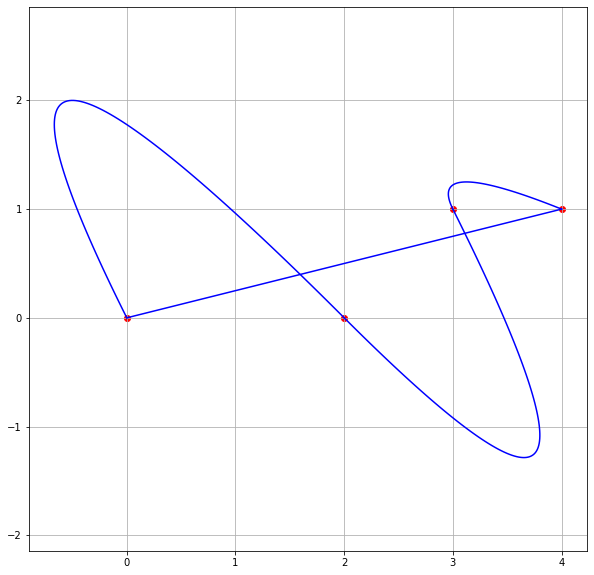

In [30]:
u1 = np.array([[-0.5,1]])
u2 = np.array([[1,-1]])
u3 = np.array([[-0.5,1]])
u4 = np.array([[1,-0.4]])
p1 = np.array([[0,0]])
p2 = np.array([[2,0]])
p3 = np.array([[3,1]])
p4 = np.array([[4,1]])
t = np.array([np.linspace(0,1,100)])
spline1 = gamma(t,p1,p2,u1,u2)
spline2 = gamma(t,p2,p3,u2,u3)
spline3 = gamma(t,p3,p4,u3,u4)
spline4 = gamma(t,p4,p1,u4,u1)
plt.plot(spline1[0],spline1[1],c='b');
plt.plot(spline2[0],spline2[1],c='b');
plt.plot(spline3[0],spline3[1],c='b');
plt.plot(spline4[0],spline4[1],c='b');
plt.scatter(p1[0,0],p1[0,1],c='r')
plt.scatter(p2[0,0],p2[0,1],c='r')
plt.scatter(p3[0,0],p3[0,1],c='r')
plt.scatter(p4[0,0],p4[0,1],c='r')
plt.axis('equal');
plt.grid();

### Intégration

#### Tâche 7
Intégrer le mécanisme d'interpolation dans (une nouvelle version de) la fonction `level_curve` qui accepte un nouveau paramètre entier `oversampling` (sur-échantillonnage) tel que :

  - si `oversampling == 1`, la fonction `level_curve` fonctionne comme précédemment,

  - si `oversampling > 1`, la fonction `level_curve` introduit dans son résultat `oversampling - 1` points supplémentaires obtenus par interpolations entre chaque couple de points consécutifs obtenus par la méthode de Newton.

---
## __Tâche 7__

Afin de pouvoir représenter graphiquement le résultat de l'interpolation, la fonction `level_curve_spline` renverra le tableau issu de l'appel `new_level_curve(f,x0,y0)` ainsi qu'une liste de liste contenant le résulat de `gamma(t,p1,p2,u1,u2)` pour tout couple de points $(p_1,p_2)$ consécutifs trouvés par `new_level_curve(f,x0,y0)`. 

In [31]:
def level_curve_spline(f, x0, y0,oversampling, delta=0.1, N2=1000, eps=eps): 
    XY = new_level_curve(f,x0,y0,delta,N2 = N2)
    if oversampling == 1:
        return XY,[[[],[]]]
    else:
        t= np.array([np.linspace(0,1,oversampling-1)])
        L = []
        k = len(XY[0])
        for i in range(k):
            p0 = np.array([XY[:,(i-1)%k]])
            p1 = np.array([XY[:,i]])
            p2 = np.array([XY[:,(i+1)%k]])
            p3 = np.array([XY[:,(i+2)%k]])
            u1 = np.array(p1-p0)
            u2 = np.array(p3-p2)
            xy = gamma(t,p1,p2,u1,u2)
            L.append(xy)
        return XY,L    

#### Tâche 8

Valider graphiquement le résultat au moyen des exemples de référence.

### __Illustration avec la fonction f1 pour la courbe f1(x) = 0.8__

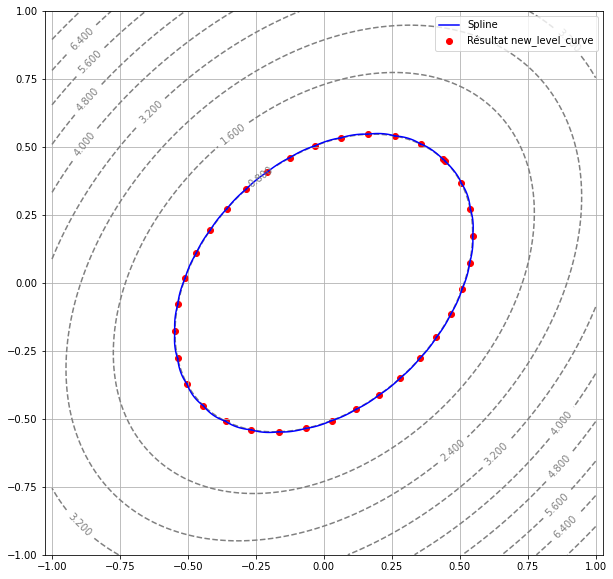

In [32]:
def f(x,y):
    return f1(x,y) - 0.8
def f_n(x,y):
    return np.array([f(x,y),C(x,y)])
x,y = Newton(f_n,0.8,0.8)

XY,L = level_curve_spline(f,x,y,101,delta=0.1 ,N2 = 500)

X0,Y0 = np.linspace(-1,1,100),np.linspace(-1,1,100)
X0,Y0 = np.meshgrid(X0,Y0)
Z = f1(X0,Y0)
CS = plt.contour(X0,Y0,Z,linestyles = 'dashed',colors = 'grey',levels = 10)
plt.clabel(CS);

for i in range(len(L)-1):
    plt.plot(L[i][0],L[i][1],c='b')
plt.plot(L[-1][0],L[-1][1],c='b', label = 'Spline')
plt.scatter(XY[0,::],XY[1,::],c='r',label = 'Résultat new_level_curve');
plt.xlim([-1,1]);
plt.ylim([-1,1]);
plt.axis('equal');
plt.legend();
plt.grid()

### __Illustration avec la fonction f2 pour la courbe f2(x) = 1__

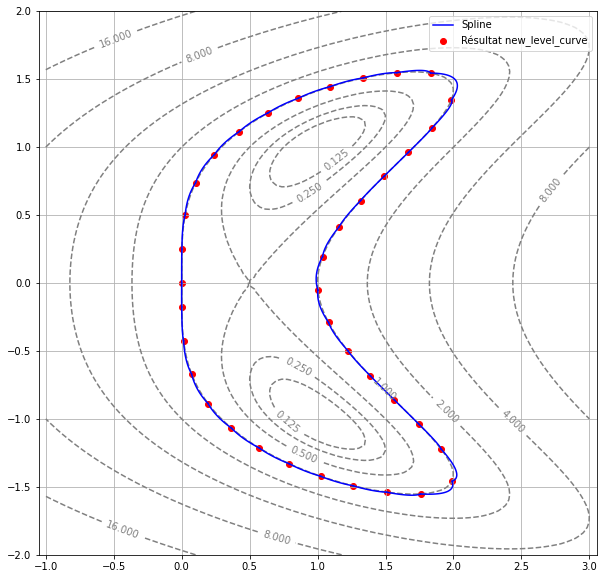

In [33]:
def f(x,y):
    return f2(x,y) - 1
def f_n(x,y):
    return np.array([f(x,y),C(x,y)])
x,y = Newton(f_n,0.5,-1.0)
XY,L  = level_curve_spline(f,x,y,101,delta = 0.25,N2 = 500)

X0,Y0 = np.linspace(-1,3,100),np.linspace(-2,2,100)
X0,Y0 = np.meshgrid(X0,Y0)
Z = f2(X0,Y0)
CS = plt.contour(X0,Y0,Z,linestyles = 'dashed',colors = 'grey',levels = [2**i for i in range(-3, 8)])
plt.clabel(CS);

for i in range(len(L)-1):
    plt.plot(L[i][0],L[i][1],c='b')
plt.plot(L[-1][0],L[-1][1],c='b', label = 'Spline')
plt.scatter(XY[0,::],XY[1,::],c='r',label = 'Résultat new_level_curve');
plt.xlim([-1,3]);
plt.ylim([-2,2]);
plt.axis('equal');
plt.legend();
plt.grid()

### __Illustration avec la fonction f3 pour la courbe f3(x) = -2.4__

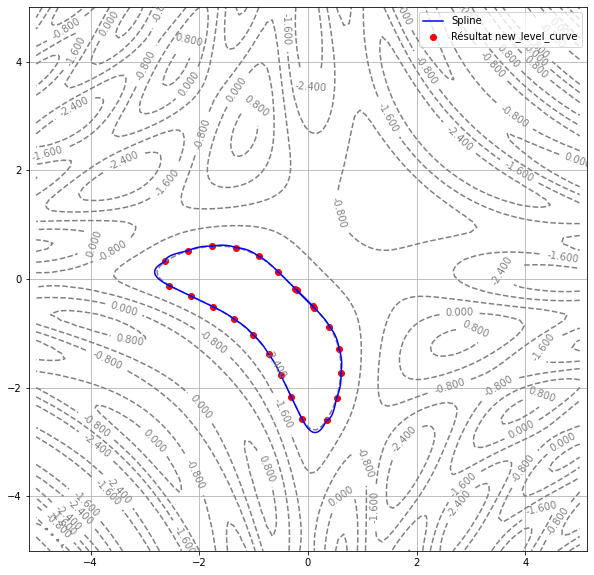

In [34]:
def f(x,y):
    return f3(x,y) + 2.4
def f_n(x,y):
    return np.array([f(x,y),C(x,y)])
x,y = Newton(f_n,0.0,0.0)
XY,L = level_curve_spline(f,x,y,101,delta = 0.45, N2 = 500)

X0,Y0 = np.linspace(-5,5,100),np.linspace(-5,5,100)
X0,Y0 = np.meshgrid(X0,Y0)
Z = f3(X0,Y0)
CS = plt.contour(X0,Y0,Z,linestyles = 'dashed',colors = 'grey',levels = 5)
plt.clabel(CS);

for i in range(len(L)-1):
    plt.plot(L[i][0],L[i][1],c='b')
plt.plot(L[-1][0],L[-1][1],c='b', label = 'Spline')
plt.scatter(XY[0,::],XY[1,::],c='r',label = 'Résultat new_level_curve');
plt.xlim([-5,5]);
plt.ylim([-5,5]);
plt.axis('equal');
plt.legend();
plt.grid()

# __Nota bene :__

On remarque sur le dernier exemple, que la méthode développée jusqu'ici ne permet que de tracer des parties connexes par arc des courbes de niveaux. On pourrait étendre la méthode pour tracer toutes les composantes connexes par ac d'une courbe de niveau dans une zone déterminée en itérant la méthode actuelle sur un maillage de la zone en question lors du premier appel à `Newton(f,x,y)` et ne continuer le tracage de la courbe seulement si le point trouvé n'appartient pas à l'une des composantes connexes déjà tracées.  